In [2]:
# ==================== Testing traj-avg Observables ====================
# This notebook tests the trajectory-averaged observables from multiple G(t) histories.
# Imports & hot-reload

import os, importlib, numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

import classA_U1FGTN as mod
importlib.reload(mod)
from classA_U1FGTN import classA_U1FGTN

In [3]:
# parameters (DW = True)
Nx, Ny   = 16, 16
Ntot = 4*Nx*Ny
Nlayer = Ntot//2
cycles   = 20
samples  = 100
nshell   = None               # None for untruncated
DW       = True
m = classA_U1FGTN(Nx, Ny, DW=DW)
DW_loc = m.DW_loc


DWs at x=(4, 11)
------------------------- classA_U1FGTN Initialized -------------------------


In [4]:
def unflatten_G(Gfull, Nx, Ny, top=True):
    """Accept (..., Ntot, Ntot) and return (..., Nx, Ny, 2, Nx, Ny, 2)."""
    Gfull = np.asarray(Gfull)
    leading = Gfull.shape[:-2]
    Nlayer = 2 * Nx * Ny
    if top and Gfull.shape[-2:] != (Nlayer, Nlayer):
        raise ValueError(f"Expected (...,{Nlayer},{Nlayer}), got {Gfull.shape}")

    # (..., μ, x, y, ν, x', y')
    G6m = Gfull.reshape(leading + (2, Nx, Ny, 2, Nx, Ny), order='F')

    base = len(leading)
    axes = list(range(base)) + [
        base + 1,  # x
        base + 2,  # y
        base + 0,  # μ
        base + 4,  # x'
        base + 5,  # y'
        base + 3,  # ν
    ]
    return np.transpose(G6m, axes)


def flatten_G(G6):
    """
    Flatten G(x, y, μ; x', y', ν) -> G_flat with index
        i = μ + 2*x + 2*Nx*y   (Fortran order on (μ, x, y)),
    supporting any leading batch dimensions.

    Input shape: (..., Nx, Ny, 2, Nx, Ny, 2)
    Output shape: (..., 2*Nx*Ny, 2*Nx*Ny)
    """
    G6 = np.asarray(G6, dtype=np.complex128)
    if G6.ndim < 6:
        raise ValueError(f"G must have at least 6 dims; got {G6.shape}")

    leading = G6.shape[:-6]
    Nx, Ny, s1, Nx2, Ny2, s2 = G6.shape[-6:]
    if not ((s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)):
        raise ValueError(
            f"G must have shape (..., Nx, Ny, 2, Nx, Ny, 2); got {G6.shape}"
        )

    base = len(leading)
    axes = list(range(base)) + [
        base + 2,  # μ
        base + 0,  # x
        base + 1,  # y
        base + 5,  # ν
        base + 3,  # x'
        base + 4,  # y'
    ]
    G6m = np.transpose(G6, axes)
    flat_shape = leading + (2 * Nx * Ny, 2 * Nx * Ny)
    return G6m.reshape(flat_shape, order="F")

In [5]:
data = np.load('cache/G_history_samples/N16x16_C20_S100_nshNone_DW1_init-default.npz', allow_pickle=True)
G = unflatten_G(data[data.files[0]][...,:Nlayer,:Nlayer], Nx, Ny)
print(G.shape, G.dtype) # G will denote the steady-state of the complex covariance with DWs

(100, 20, 16, 16, 2, 16, 16, 2) complex128


In [6]:
G_avg = G.mean(axis=0)
print(G_avg.shape, G_avg.dtype)

(20, 16, 16, 2, 16, 16, 2) complex128


In [7]:
data_mixed = np.load('cache/G_history_samples/N16x16_C20_S100_nshNone_DW1_init-maxmix.npz', allow_pickle=True)
G_mixed = unflatten_G(data_mixed[data_mixed.files[0]][...,:Nlayer,:Nlayer], Nx, Ny)
print(G_mixed.shape, G_mixed.dtype)
G_mixed_avg = G_mixed.mean(axis=0)

(100, 20, 16, 16, 2, 16, 16, 2) complex128


In [12]:
def two_point_from_covariance(complex_covar, Nx, Ny):
    """Convert a complex covariance G -> (1/2)(G + I) with shape preserved."""
    cov = np.asarray(complex_covar, dtype=np.complex128)
    Nlayer = 2 * Nx * Ny

    if cov.shape[-2:] == (Nlayer, Nlayer):
        cov_flat = cov
        reshape_back = False
    elif cov.shape[-6:] == (Nx, Ny, 2, Nx, Ny, 2):
        cov_flat = flatten_G(cov)
        reshape_back = True
    else:
        raise ValueError(
            f"Expected (...,{Nlayer},{Nlayer}) or "
            f"(...,{Nx},{Ny},2,{Nx},{Ny},2); got {cov.shape}"
        )

    leading = cov_flat.shape[:-2]
    eye = np.eye(Nlayer, dtype=cov_flat.dtype).reshape(
        (1,) * len(leading) + (Nlayer, Nlayer)
    )
    two_flat = 0.5 * (cov_flat + eye)

    return unflatten_G(two_flat, Nx, Ny, top=True) if reshape_back else two_flat

In [13]:
def squared_two_point_corr_xslice(G6, Nx, Ny, x0=None, ry_max=None):
    """Return |G|² averaged along column x0; works for G6 with leading batch axes."""
    G6 = np.asarray(two_point_from_covariance(G6, Nx, Ny))
    if G6.shape[-6:] != (Nx, Ny, 2, Nx, Ny, 2):
        raise ValueError(f"Expected (...,{Nx},{Ny},2,{Nx},{Ny},2), got {G6.shape}")

    if x0 is None:
        x0 = Nx // 2

    ry_arr = np.arange(Ny // 2 if ry_max is None else ry_max, dtype=np.intp)
    R = ry_arr.size
    leading = G6.shape[:-6]

    Gx = G6[..., x0, :, :, x0, :, :]  # (..., Ny, 2, Ny, 2)
    axes = list(range(Gx.ndim - 4)) + [Gx.ndim - 4, Gx.ndim - 2, Gx.ndim - 3, Gx.ndim - 1]
    Gx_re = np.transpose(Gx, axes).reshape(leading + (Ny * Ny, 2, 2))

    Y = np.arange(Ny, dtype=np.intp)[:, None]
    flat_idx = (Y * Ny + (Y + ry_arr) % Ny).reshape(-1)

    blocks = np.take(Gx_re, flat_idx, axis=-3).reshape(leading + (Ny, R, 2, 2))
    vals = np.abs(blocks) ** 2
    C = vals.sum(axis=(-1, -2)).sum(axis=-2) / (2.0 * Ny)

    return C


(20, 8)
(20, 8)


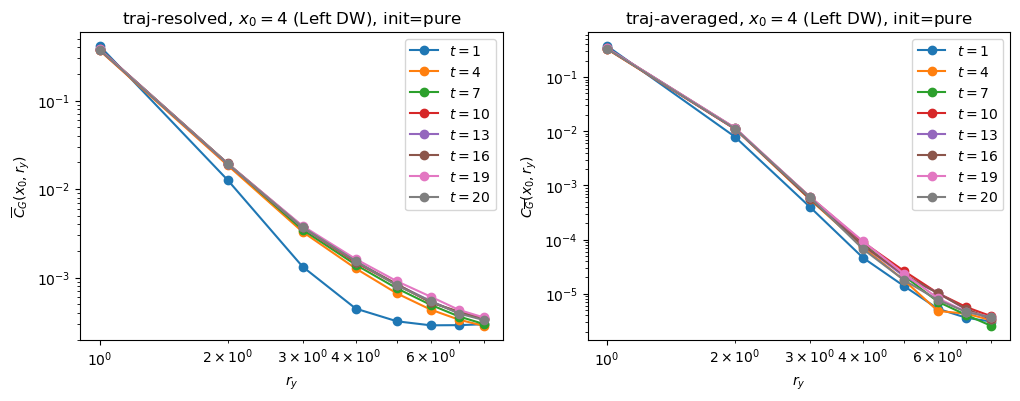

In [14]:
x_DW1 = DW_loc[0] # left DW position
avg_C_G = squared_two_point_corr_xslice(G, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_avg = squared_two_point_corr_xslice(G_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G.shape)
print(C_G_avg.shape)

# Comparing traj-resolved and traj-avged correlators spatial decay for multiple time-steps along left DW
# Choose cycles: include first, every third, and last
T = avg_C_G.shape[0]
cycle_idx = np.unique(np.concatenate(([0], np.arange(0, T, 3), [T - 1])))
y_vals = np.arange(1, Ny // 2 + 1, dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G, fr'traj-resolved, $x_0={x_DW1}$ (Left DW), init=pure'),
    (axes[1], C_G_avg, fr'traj-averaged, $x_0={x_DW1}$ (Left DW), init=pure'),
]:
    for idx in cycle_idx:
        ax.plot(y_vals, data[idx], '-o', label=fr'$t = {idx+1}$')
    ax.set_xlabel(r'$r_y$')
    ax.set_title(title)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')

plt.show()

(20, 8)
(20, 8)


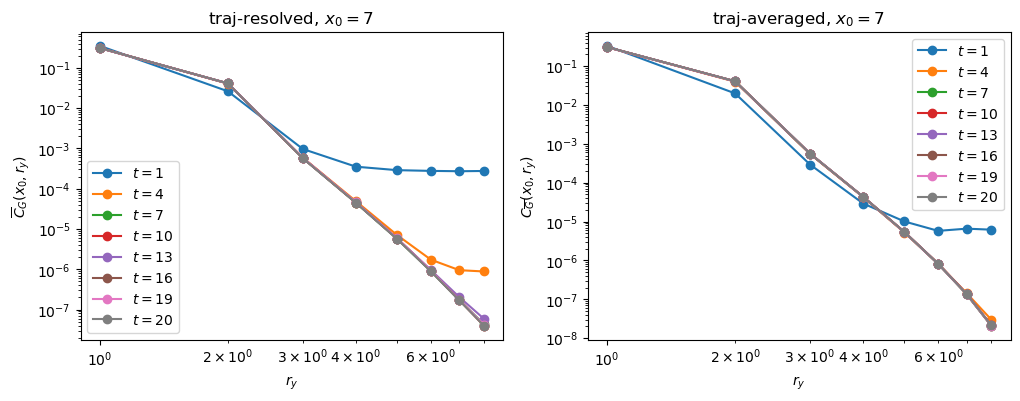

In [15]:
x_DW1 = 7 # left DW position
avg_C_G = squared_two_point_corr_xslice(G, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_avg = squared_two_point_corr_xslice(G_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G.shape)
print(C_G_avg.shape)

# Comparing traj-resolved and traj-avged correlators spatial decay for multiple time-steps along left DW
# Choose cycles: include first, every third, and last
T = avg_C_G.shape[0]
cycle_idx = np.unique(np.concatenate(([0], np.arange(0, T, 3), [T - 1])))
y_vals = np.arange(1, Ny // 2 + 1, dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G, fr'traj-resolved, $x_0={x_DW1}$ '),
    (axes[1], C_G_avg, fr'traj-averaged, $x_0={x_DW1}$ '),
]:
    for idx in cycle_idx:
        ax.plot(y_vals, data[idx], '-o', label=fr'$t = {idx+1}$')
    ax.set_xlabel(r'$r_y$')
    ax.set_title(title)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')

plt.show()

/tmp/ipykernel_2931304/89069901.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


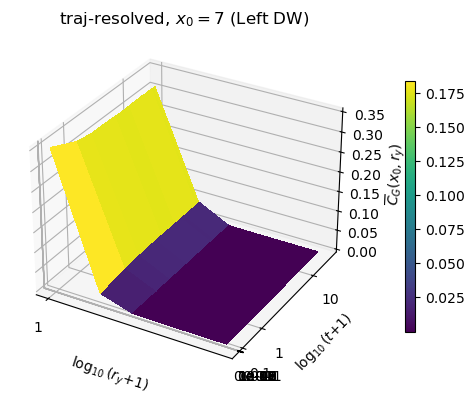

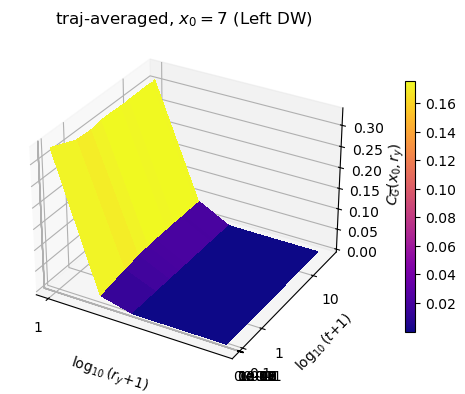

In [16]:
# In Jupyter, uncomment the next line (requires: pip install ipympl)
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- your data shapes ---
T, R = avg_C_G.shape
t_vals = np.arange(T, dtype=float)
r_vals = np.arange(1, Ny // 2 + 1, dtype=float)

# Meshgrid in linear coordinates
R_grid, T_grid = np.meshgrid(r_vals, t_vals, indexing="xy")

# Shift to avoid log(0)
R_log = np.log10(R_grid + 1.0)   # shift by +1 → keeps 1→0 region well-defined
T_log = np.log10(T_grid + 1.0)

# Precompute nice log ticks & labels (in linear units)
def pow10_ticks(vmin, vmax):
    lo = int(np.floor(np.log10(max(vmin, 1e-12))))
    hi = int(np.ceil(np.log10(vmax)))
    ticks = (10.0 ** np.arange(lo, hi + 1)).astype(float)
    return ticks[(ticks >= vmin) & (ticks <= vmax)]

r_ticks = pow10_ticks(r_vals.min(), r_vals.max() + 1)
t_ticks = pow10_ticks(t_vals.min(), t_vals.max() + 1)

# ---------------- Surface 1: trajectory-resolved ----------------
fig1 = plt.figure(figsize=(6, 5))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(
    R_log, T_log, avg_C_G,
    cmap='viridis', linewidth=0, antialiased=False, rstride=1, cstride=1
)
ax1.set_xlabel(r'$\log_{10}(r_y{+}1)$')
ax1.set_ylabel(r'$\log_{10}(t{+}1)$')
ax1.set_zlabel(r'$\overline{C}_G(x_0, r_y)$')
ax1.set_title(fr'traj-resolved, $x_0={x_DW1}$ (Left DW)')
fig1.colorbar(surf1, ax=ax1, shrink=0.65, pad=0.1, aspect=25)
ax1.view_init(elev=30, azim=-60)

# tick labels in linear units
ax1.set_xticks(np.log10(r_ticks + 1))
ax1.set_xticklabels([f"{int(v)}" if v.is_integer() else f"{v:g}" for v in r_ticks])
ax1.set_yticks(np.log10(t_ticks + 1))
ax1.set_yticklabels([f"{int(v)}" if v.is_integer() else f"{v:g}" for v in t_ticks])

# ---------------- Surface 2: trajectory-averaged ----------------
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(
    R_log, T_log, C_G_avg,
    cmap='plasma', linewidth=0, antialiased=False, rstride=1, cstride=1
)
ax2.set_xlabel(r'$\log_{10}(r_y{+}1)$')
ax2.set_ylabel(r'$\log_{10}(t{+}1)$')
ax2.set_zlabel(r'$C_{\overline{G}}(x_0, r_y)$')
ax2.set_title(fr'traj-averaged, $x_0={x_DW1}$ (Left DW)')
fig2.colorbar(surf2, ax=ax2, shrink=0.65, pad=0.1, aspect=25)
ax2.view_init(elev=30, azim=-60)

ax2.set_xticks(np.log10(r_ticks + 1))
ax2.set_xticklabels([f"{int(v)}" if v.is_integer() else f"{v:g}" for v in r_ticks])
ax2.set_yticks(np.log10(t_ticks + 1))
ax2.set_yticklabels([f"{int(v)}" if v.is_integer() else f"{v:g}" for v in t_ticks])

plt.tight_layout()
plt.show()

(20, 8)
(20, 8)


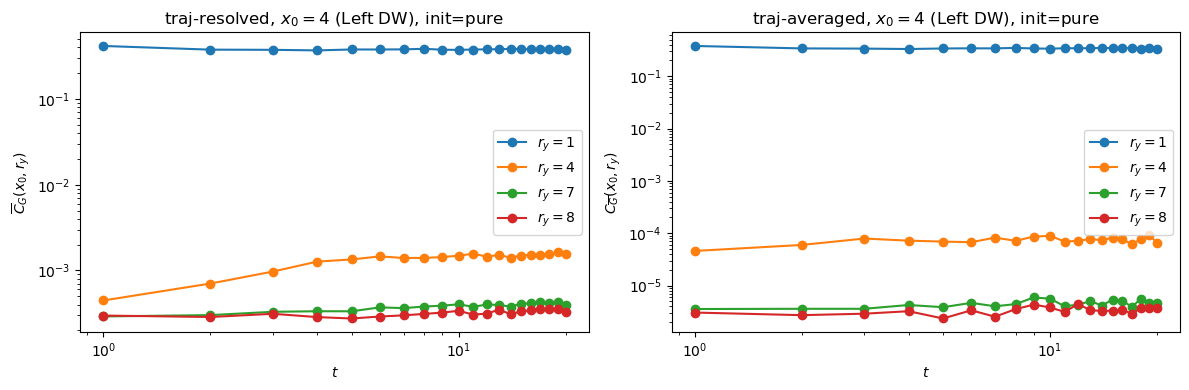

In [27]:
# Comparing traj-resolved vs traj-averaged temporal decay along fixed r_y slices
x_DW1 = DW_loc[0] # left DW position
avg_C_G = squared_two_point_corr_xslice(G, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_avg = squared_two_point_corr_xslice(G_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G.shape)
print(C_G_avg.shape)

T = avg_C_G.shape[0]
t_vals = np.arange(1, T + 1, dtype=float)

# pick representative r_y values: include 1, every third, and Ny//2
ry_idx = np.unique(np.concatenate(([0], np.arange(0, Ny // 2, 3), [Ny // 2 - 1])))
ry_vals = (ry_idx + 1).astype(float)  # physical r_y starts at 1

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G, fr'traj-resolved, $x_0={x_DW1}$ (Left DW), init=pure'),
    (axes[1], C_G_avg, fr'traj-averaged, $x_0={x_DW1}$ (Left DW), init=pure'),
]:
    for idx, ry in zip(ry_idx, ry_vals):
        ax.plot(t_vals, data[:, idx], '-o', label=fr'$r_y = {int(ry)}$')
    ax.set_xlabel(r'$t$')
    ax.set_title(title)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')


axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')
plt.tight_layout()
plt.show()


(20, 8)
(20, 8)


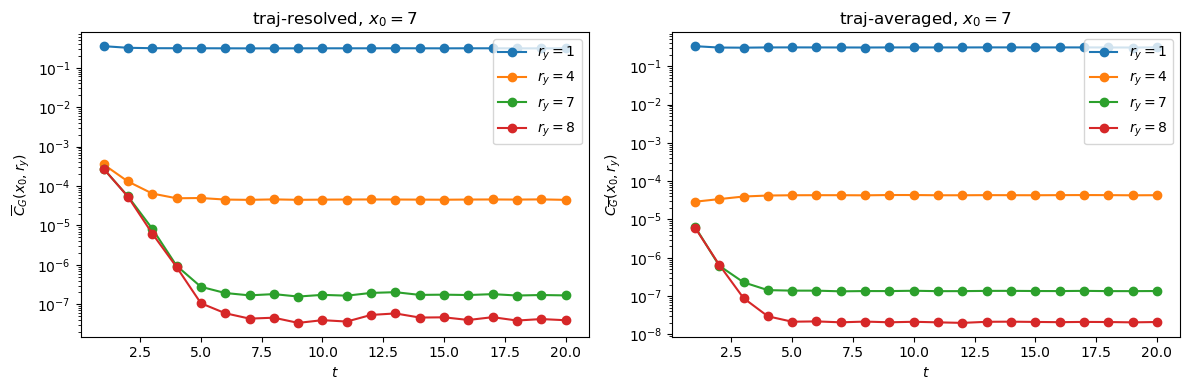

In [18]:
# Comparing traj-resolved vs traj-averaged temporal decay along fixed r_y slices
x_DW1 = 7 # left DW position
avg_C_G = squared_two_point_corr_xslice(G, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_avg = squared_two_point_corr_xslice(G_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G.shape)
print(C_G_avg.shape)

T = avg_C_G.shape[0]
t_vals = np.arange(1, T + 1, dtype=float)

# pick representative r_y values: include 1, every third, and Ny//2
ry_idx = np.unique(np.concatenate(([0], np.arange(0, Ny // 2, 3), [Ny // 2 - 1])))
ry_vals = (ry_idx + 1).astype(float)  # physical r_y starts at 1

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G, fr'traj-resolved, $x_0={x_DW1}$'),
    (axes[1], C_G_avg, fr'traj-averaged, $x_0={x_DW1}$'),
]:
    for idx, ry in zip(ry_idx, ry_vals):
        ax.plot(t_vals, data[:, idx], '-o', label=fr'$r_y = {int(ry)}$')
    ax.set_xlabel(r'$t$')
    ax.set_title(title)
    ax.legend()
    ax.set_yscale('log')


axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')
plt.tight_layout()
plt.show()

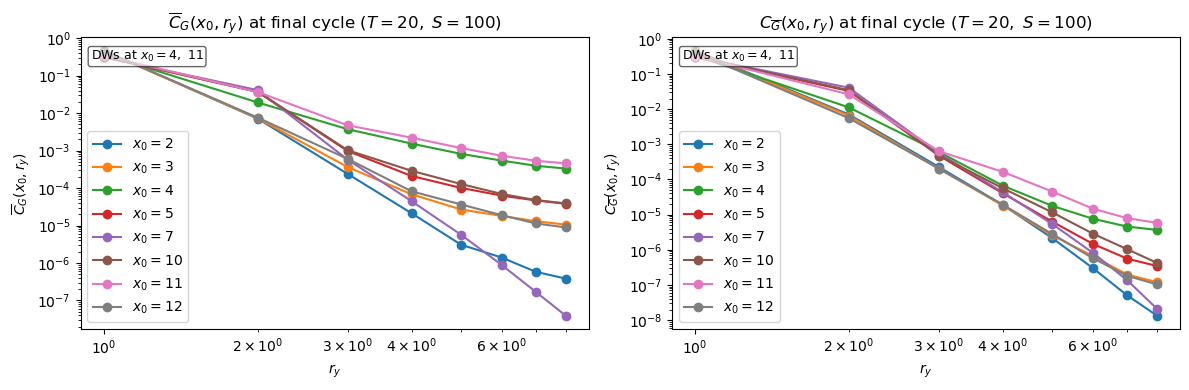

In [19]:

def _pick_x_positions(m, Nx):
    """Mirror the helper from classA_U1FGTN."""
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL = int(m.DW_loc[0]) % Nx
        xR = int(m.DW_loc[1]) % Nx
        candidates = [
            (xL // 2) % Nx,
            (xL - 1) % Nx, xL, (xL + 1) % Nx,
            ((xL + xR) // 2) % Nx,
            (xR - 1) % Nx, xR, (xR + 1) % Nx,
            (xR + (Nx // 2)) % Nx,
        ]
        seen, uniq = set(), []
        for x in candidates:
            if x not in seen:
                uniq.append(int(x))
                seen.add(int(x))
        return uniq
    xs = np.linspace(0, Nx - 1, 9, dtype=int)
    return [int(x) for x in xs]

x_list = _pick_x_positions(m, Nx)
ry_vals = np.arange(1, Ny // 2 + 1, dtype=float)
last_cycle = -1  # final time slice

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for x0 in x_list:
    C_G_avg_full = squared_two_point_corr_xslice(G_avg, Nx, Ny, x0=x0)           # shape (T, Ny//2)
    avg_C_G_full = squared_two_point_corr_xslice(G, Nx, Ny, x0=x0).mean(axis=0)  # shape (T, Ny//2)
    axes[1].plot(ry_vals, C_G_avg_full[last_cycle], marker='o', label=fr'$x_0={x0}$')
    axes[0].plot(ry_vals, avg_C_G_full[last_cycle], marker='o', label=fr'$x_0={x0}$')

axes[1].set_title(r'$C_{\overline{G}}(x_0, r_y)$ at final cycle ($T=20, \ S=100$)')
axes[0].set_title(r'$\overline{C}_G(x_0, r_y)$ at final cycle ($T=20, \ S=100$)')
axes[0].set_xlabel(r'$r_y$')
axes[1].set_xlabel(r'$r_y$')
axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_\overline{G}(x_0, r_y)$')

for ax in axes:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL, xR = map(int, m.DW_loc)
        ax.text(
            0.02,
            0.96,
            fr"DWs at $x_0 = {xL},\ {xR}$",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="k", alpha=0.6),
        )

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

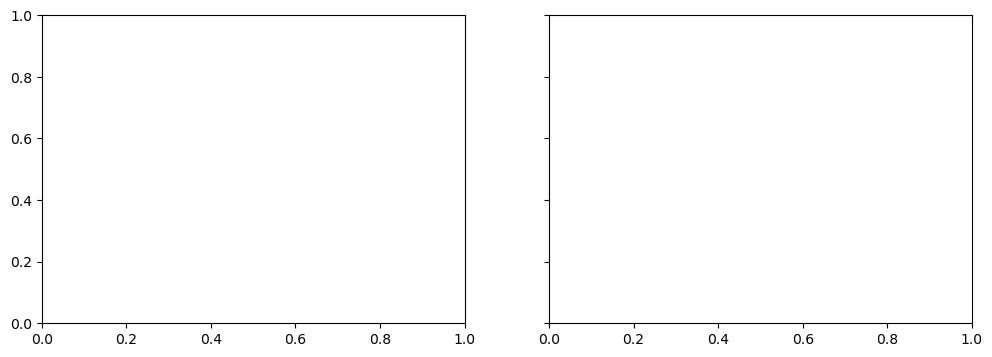

In [20]:
def hermitian_flatten_covariance(G):
    """
    Symmetrise the last six indices of (..., Nx, Ny, 2, Nx, Ny, 2) and
    return the flattened Hermitian matrix with shape (..., 2*Nx*Ny, 2*Nx*Ny).
    """
    G = np.asarray(G, dtype=np.complex128)
    if G.ndim < 6:
        raise ValueError(f"Need (..., Nx, Ny, 2, Nx, Ny, 2); got {G.shape}")

    leading = G.shape[:-6]
    tail = G.shape[-6:]
    dim = int(np.prod(tail[:3]))
    if dim != int(np.prod(tail[3:])):
        raise ValueError(f"Last six axes must form a square block; got {tail}")

    Gflat = G.reshape(leading + (dim, dim))
    return 0.5 * (Gflat + np.swapaxes(Gflat.conj(), -1, -2))

# Example usage for spectra
traj0 = np.asarray(G[0])
T = traj0.shape[0]
cycle_idx = np.unique(np.concatenate(([0], np.arange(0, T, 3), [T - 1])))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for idx in cycle_idx:
    eigvals_avg_t = np.linalg.eigvalsh(hermitian_flatten_covariance(G_avg[idx]))
    axes[0].plot(np.arange(eigvals_avg_t.size), eigvals_avg_t, '-o',
                 label=fr'$t = {idx + 1}$')

for idx in cycle_idx:
    eigvals_t = np.linalg.eigvalsh(hermitian_flatten_covariance(traj0[idx]))
    axes[1].plot(np.arange(eigvals_t.size), eigvals_t, '-o',
                 label=fr'$t = {idx + 1}$')

axes[1].set_title(r'Spectra of $\overline{G}(t)$')
axes[1].set_xlabel(r'eigenvalue index $i$')
axes[1].set_ylabel(r'$\lambda_i$')
axes[1].legend()

axes[0].set_title(r'Spectra of $G(t)$ for a single traj')
axes[0].set_xlabel(r'eigenvalue index $i$')
axes[0].legend()


plt.tight_layout()
plt.show()


In [16]:
# ================================== Max-Mixed State Plots Below ====================================


(20, 8)
(20, 8)


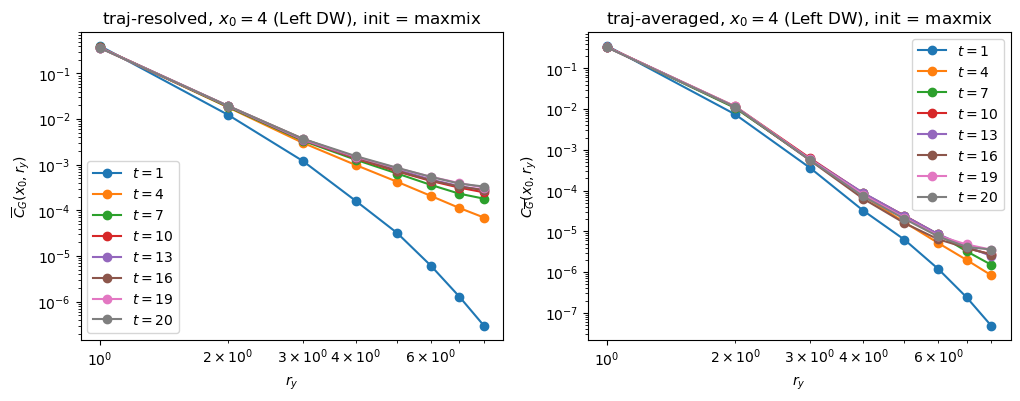

In [21]:
# Comparing traj-resolved and traj-avged correlators spatial decay for multiple time-steps along left DW
# Choose cycles: include first, every third, and last
x_DW1 = DW_loc[0] # left DW position
avg_C_G_mixed = squared_two_point_corr_xslice(G_mixed, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_mixed_avg = squared_two_point_corr_xslice(G_mixed_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G_mixed.shape)
print(C_G_mixed_avg.shape)
T = avg_C_G_mixed.shape[0]
cycle_idx = np.unique(np.concatenate(([0], np.arange(0, T, 3), [T - 1])))
y_vals = np.arange(1, Ny // 2 + 1, dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G_mixed, fr'traj-resolved, $x_0={x_DW1}$ (Left DW), init = maxmix'),
    (axes[1], C_G_mixed_avg, fr'traj-averaged, $x_0={x_DW1}$ (Left DW), init = maxmix'),
]:
    for idx in cycle_idx:
        ax.plot(y_vals, data[idx], '-o', label=fr'$t = {idx+1}$')
    ax.set_xlabel(r'$r_y$')
    ax.set_title(title)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')

plt.show()

(20, 8)
(20, 8)


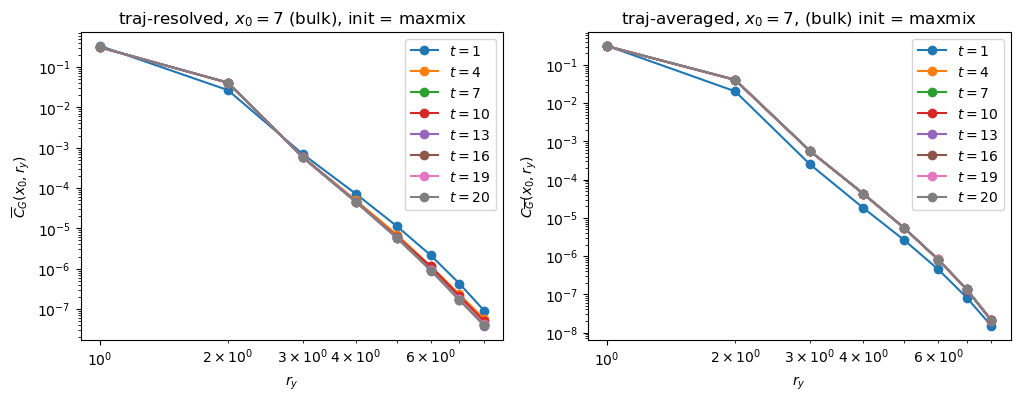

In [22]:
# Comparing traj-resolved and traj-avged correlators spatial decay for multiple time-steps along left DW
# Choose cycles: include first, every third, and last
x_DW1 = 7 # left DW position
avg_C_G_mixed = squared_two_point_corr_xslice(G_mixed, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_mixed_avg = squared_two_point_corr_xslice(G_mixed_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G_mixed.shape)
print(C_G_mixed_avg.shape)
T = avg_C_G_mixed.shape[0]
cycle_idx = np.unique(np.concatenate(([0], np.arange(0, T, 3), [T - 1])))
y_vals = np.arange(1, Ny // 2 + 1, dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G_mixed, fr'traj-resolved, $x_0={x_DW1}$ (bulk), init = maxmix'),
    (axes[1], C_G_mixed_avg, fr'traj-averaged, $x_0={x_DW1}$, (bulk) init = maxmix'),
]:
    for idx in cycle_idx:
        ax.plot(y_vals, data[idx], '-o', label=fr'$t = {idx+1}$')
    ax.set_xlabel(r'$r_y$')
    ax.set_title(title)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')

plt.show()

(20, 8)


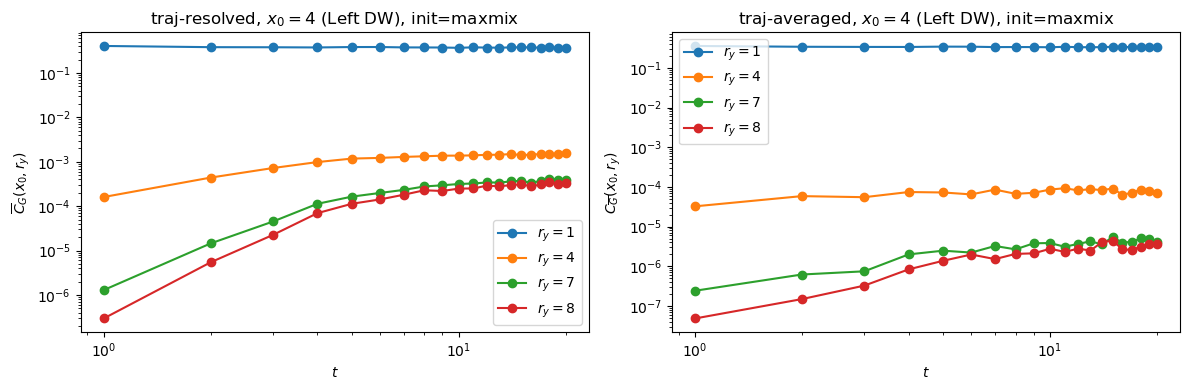

In [26]:
# Comparing traj-resolved vs traj-averaged temporal decay along fixed r_y slices
x_DW1 = DW_loc[0] # left DW position
avg_C_G_mixed = squared_two_point_corr_xslice(G_mixed, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_mixed_avg = squared_two_point_corr_xslice(G_mixed_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G_mixed.shape)
T = avg_C_G_mixed.shape[0]
t_vals = np.arange(1, T + 1, dtype=float)

# pick representative r_y values: include 1, every third, and Ny//2
ry_idx = np.unique(np.concatenate(([0], np.arange(0, Ny // 2, 3), [Ny // 2 - 1])))
ry_vals = (ry_idx + 1).astype(float)  # physical r_y starts at 1

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G_mixed, fr'traj-resolved, $x_0={x_DW1}$ (Left DW), init=maxmix'),
    (axes[1], C_G_mixed_avg, fr'traj-averaged, $x_0={x_DW1}$ (Left DW), init=maxmix'),
]:
    for idx, ry in zip(ry_idx, ry_vals):
        ax.plot(t_vals, data[:, idx], '-o', label=fr'$r_y = {int(ry)}$')
    ax.set_xlabel(r'$t$')
    ax.set_title(title)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')


axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')
plt.tight_layout()
plt.show()

(20, 8)


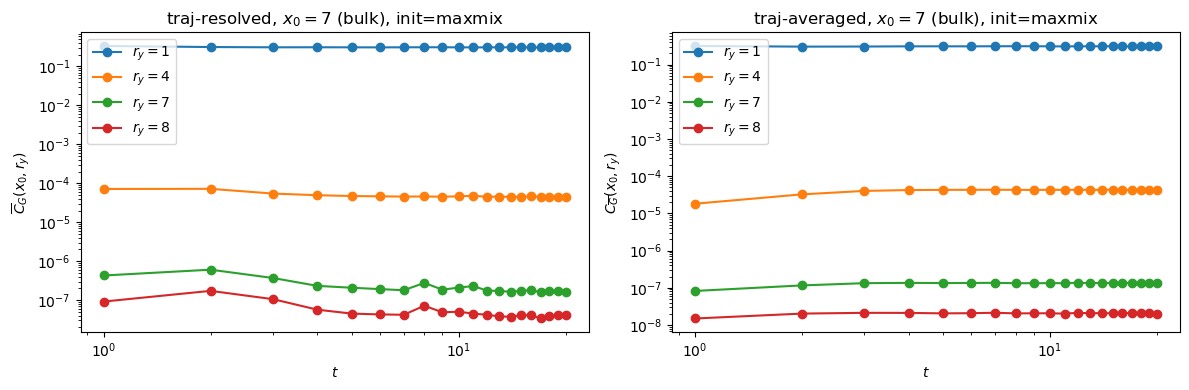

In [24]:
# Comparing traj-resolved vs traj-averaged temporal decay along fixed r_y slices
x_DW1 = 7 # left DW position
avg_C_G_mixed = squared_two_point_corr_xslice(G_mixed, Nx, Ny, x0=x_DW1).mean(axis=0) # trajectory-resolved C(x0, y)
C_G_mixed_avg = squared_two_point_corr_xslice(G_mixed_avg, Nx, Ny, x0=x_DW1) # trajectory-averaged C(x0, y)
print(avg_C_G_mixed.shape)
T = avg_C_G_mixed.shape[0]
t_vals = np.arange(1, T + 1, dtype=float)

# pick representative r_y values: include 1, every third, and Ny//2
ry_idx = np.unique(np.concatenate(([0], np.arange(0, Ny // 2, 3), [Ny // 2 - 1])))
ry_vals = (ry_idx + 1).astype(float)  # physical r_y starts at 1

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title in [
    (axes[0], avg_C_G_mixed, fr'traj-resolved, $x_0={x_DW1}$ (bulk), init=maxmix'),
    (axes[1], C_G_mixed_avg, fr'traj-averaged, $x_0={x_DW1}$ (bulk), init=maxmix'),
]:
    for idx, ry in zip(ry_idx, ry_vals):
        ax.plot(t_vals, data[:, idx], '-o', label=fr'$r_y = {int(ry)}$')
    ax.set_xlabel(r'$t$')
    ax.set_title(title)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')


axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_{\overline{G}}(x_0, r_y)$')
plt.tight_layout()
plt.show()

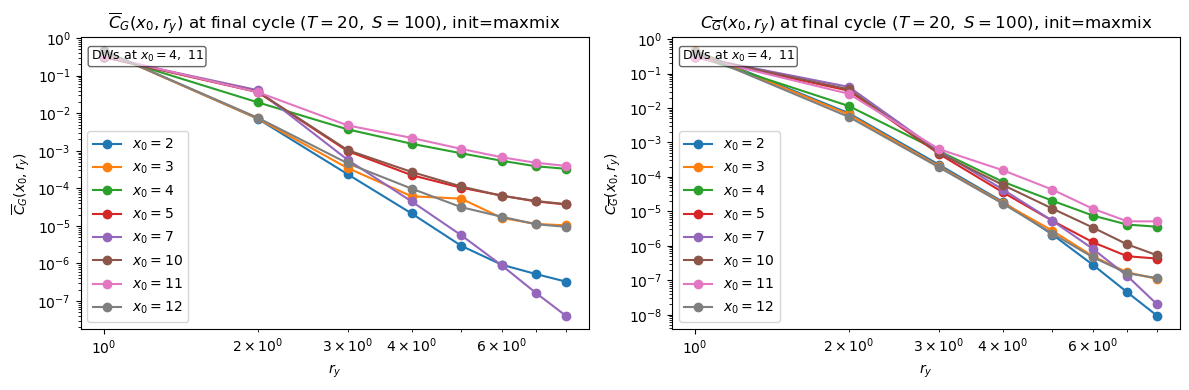

In [25]:
def _pick_x_positions(m, Nx):
    """Mirror the helper from classA_U1FGTN."""
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL = int(m.DW_loc[0]) % Nx
        xR = int(m.DW_loc[1]) % Nx
        candidates = [
            (xL // 2) % Nx,
            (xL - 1) % Nx, xL, (xL + 1) % Nx,
            ((xL + xR) // 2) % Nx,
            (xR - 1) % Nx, xR, (xR + 1) % Nx,
            (xR + (Nx // 2)) % Nx,
        ]
        seen, uniq = set(), []
        for x in candidates:
            if x not in seen:
                uniq.append(int(x))
                seen.add(int(x))
        return uniq
    xs = np.linspace(0, Nx - 1, 9, dtype=int)
    return [int(x) for x in xs]

x_list = _pick_x_positions(m, Nx)
ry_vals = np.arange(1, Ny // 2 + 1, dtype=float)
last_cycle = -1  # final time slice

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for x0 in x_list:
    C_G_avg_full = squared_two_point_corr_xslice(G_mixed_avg, Nx, Ny, x0=x0)           # shape (T, Ny//2)
    avg_C_G_full = squared_two_point_corr_xslice(G_mixed, Nx, Ny, x0=x0).mean(axis=0)  # shape (T, Ny//2)
    axes[1].plot(ry_vals, C_G_avg_full[last_cycle], marker='o', label=fr'$x_0={x0}$')
    axes[0].plot(ry_vals, avg_C_G_full[last_cycle], marker='o', label=fr'$x_0={x0}$')

axes[1].set_title(r'$C_{\overline{G}}(x_0, r_y)$ at final cycle ($T=20, \ S=100$), init=maxmix')
axes[0].set_title(r'$\overline{C}_G(x_0, r_y)$ at final cycle ($T=20, \ S=100$), init=maxmix')
axes[0].set_xlabel(r'$r_y$')
axes[1].set_xlabel(r'$r_y$')
axes[0].set_ylabel(r'$\overline{C}_G(x_0, r_y)$')
axes[1].set_ylabel(r'$C_\overline{G}(x_0, r_y)$')

for ax in axes:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL, xR = map(int, m.DW_loc)
        ax.text(
            0.02,
            0.96,
            fr"DWs at $x_0 = {xL},\ {xR}$",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="k", alpha=0.6),
        )

plt.tight_layout()
plt.show()


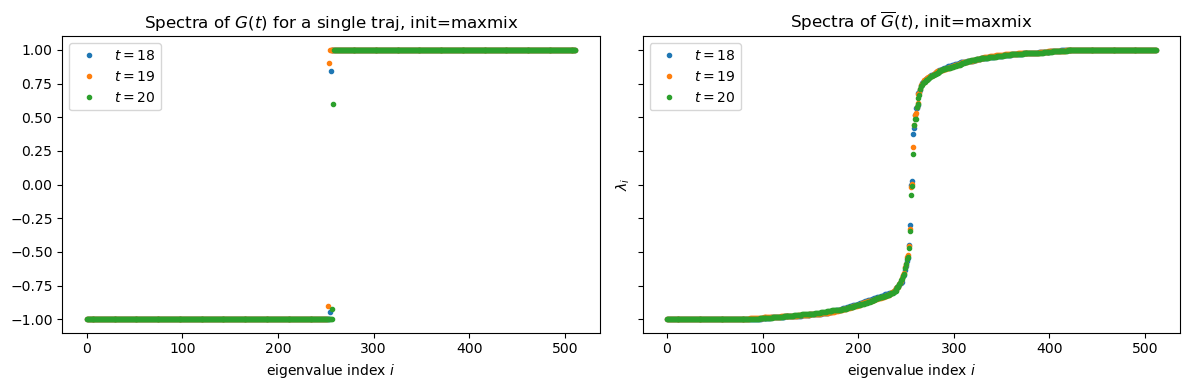

In [35]:
def hermitian_flatten_covariance(G):
    """
    Symmetrise the last six indices of (..., Nx, Ny, 2, Nx, Ny, 2) and
    return the flattened Hermitian matrix with shape (..., 2*Nx*Ny, 2*Nx*Ny).
    """
    G = np.asarray(G, dtype=np.complex128)
    if G.ndim < 6:
        raise ValueError(f"Need (..., Nx, Ny, 2, Nx, Ny, 2); got {G.shape}")

    leading = G.shape[:-6]
    tail = G.shape[-6:]
    dim = int(np.prod(tail[:3]))
    if dim != int(np.prod(tail[3:])):
        raise ValueError(f"Last six axes must form a square block; got {tail}")

    Gflat = G.reshape(leading + (dim, dim))
    return 0.5 * (Gflat + np.swapaxes(Gflat.conj(), -1, -2))

# Example usage for spectra
traj0 = np.asarray(G_mixed[0])
T = traj0.shape[0]
cycle_idx = [T-3, T-2, T-1]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for idx in cycle_idx:
    eigvals_avg_t = np.linalg.eigvalsh(hermitian_flatten_covariance(G_mixed_avg[idx]))
    axes[1].plot(np.arange(eigvals_avg_t.size), eigvals_avg_t, 'o',
                 label=fr'$t = {idx + 1}$', markersize = 3)

for idx in cycle_idx:
    eigvals_t = np.linalg.eigvalsh(hermitian_flatten_covariance(traj0[idx]))
    axes[0].plot(np.arange(eigvals_t.size), eigvals_t, 'o',
                 label=fr'$t = {idx + 1}$', markersize = 3)

axes[1].set_title(r'Spectra of $\overline{G}(t)$, init=maxmix')
axes[1].set_xlabel(r'eigenvalue index $i$')
axes[1].set_ylabel(r'$\lambda_i$')
axes[1].legend()

axes[0].set_title(r'Spectra of $G(t)$ for a single traj, init=maxmix')
axes[0].set_xlabel(r'eigenvalue index $i$')
axes[0].legend()


plt.tight_layout()
plt.show()


t = 18: count(-1) = 251, count(1) = 255, count(else) = 6
t = 19: count(-1) = 249, count(1) = 257, count(else) = 6
t = 20: count(-1) = 255, count(1) = 252, count(else) = 5


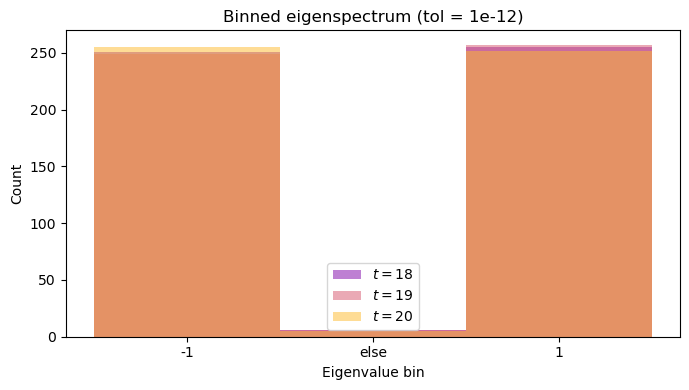

In [36]:
tol = 1e-12
time_steps = [18, 19, 20]            # 1-based; convert to zero-based below
bin_edges = [-1.5, -0.5, 0.5, 1.5]   # centers at -1, 0 ("else"), 1
xticks = [-1, 0, 1]
xtick_labels = ['-1', 'else', '1']
colors = plt.cm.plasma(np.linspace(0.25, 0.85, len(time_steps)))

fig, ax = plt.subplots(figsize=(7, 4))

for color, t in zip(colors, time_steps):
    idx = t - 1
    eigvals = np.linalg.eigvalsh(hermitian_flatten_covariance(traj0[idx]))
    categories = np.full(eigvals.shape, 0, dtype=int)  # default “else”
    categories[np.isclose(eigvals, -1.0, atol=tol)] = -1
    categories[np.isclose(eigvals,  1.0, atol=tol)] = 1

    count_neg1 = np.sum(categories == -1)
    count_pos1 = np.sum(categories == 1)
    count_else = np.sum(categories == 0)
    print(f"t = {t}: count(-1) = {count_neg1}, count(1) = {count_pos1}, count(else) = {count_else}")

    ax.hist(
        categories,
        bins=bin_edges,
        alpha=0.5,
        color=color,
        label=fr'$t = {t}$',
        align='mid'
    )

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Eigenvalue bin')
ax.set_ylabel('Count')
ax.set_title(f'Binned eigenspectrum (tol = {tol:.0e})')
ax.legend()
plt.tight_layout()
plt.show()

t = 18: count(else) = 6
t = 19: count(else) = 6
t = 20: count(else) = 5


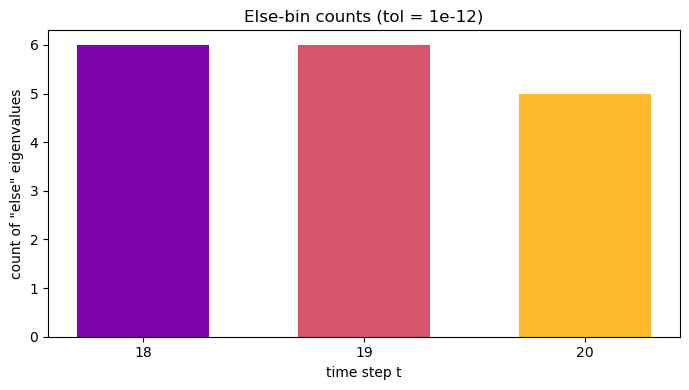

In [39]:
tol = 1e-12
time_steps = [18, 19, 20]            # 1-based; convert to zero-based below
colors = plt.cm.plasma(np.linspace(0.25, 0.85, len(time_steps)))

else_counts = []
for t in time_steps:
    idx = t - 1
    eigvals = np.linalg.eigvalsh(hermitian_flatten_covariance(traj0[idx]))
    categories = np.full(eigvals.shape, 0, dtype=int)  # default “else”
    categories[np.isclose(eigvals, -1.0, atol=tol)] = -1
    categories[np.isclose(eigvals,  1.0, atol=tol)] = 1
    count_else = int(np.sum(categories == 0))
    else_counts.append(count_else)
    print(f"t = {t}: count(else) = {count_else}")

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(time_steps, else_counts, color=colors, width=0.6)
ax.set_xticks(time_steps)
ax.set_xlabel('time step t')
ax.set_ylabel('count of "else" eigenvalues')
ax.set_title(f'Else-bin counts (tol = {tol:.0e})')
plt.tight_layout()
plt.show()

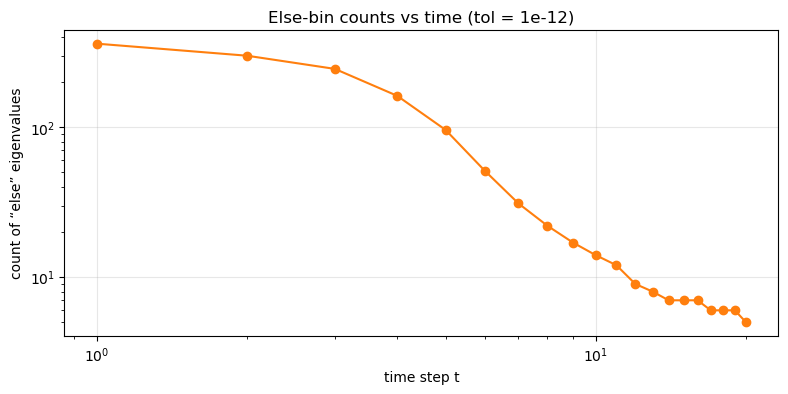

t =   1 : count(else) = 361
t =   2 : count(else) = 300
t =   3 : count(else) = 245
t =   4 : count(else) = 162
t =   5 : count(else) = 96
t =   6 : count(else) = 51
t =   7 : count(else) = 31
t =   8 : count(else) = 22
t =   9 : count(else) = 17
t =  10 : count(else) = 14
t =  11 : count(else) = 12
t =  12 : count(else) = 9
t =  13 : count(else) = 8
t =  14 : count(else) = 7
t =  15 : count(else) = 7
t =  16 : count(else) = 7
t =  17 : count(else) = 6
t =  18 : count(else) = 6
t =  19 : count(else) = 6
t =  20 : count(else) = 5


In [43]:
tol = 1e-12
time_indices = np.arange(traj0.shape[0])      # zero-based indices
time_steps = time_indices + 1                       # if you prefer 1-based labels

else_counts = np.empty_like(time_indices, dtype=int)

for i, idx in enumerate(time_indices):
    eigvals = np.linalg.eigvalsh(hermitian_flatten_covariance(traj0[idx]))
    categories = np.full(eigvals.shape, 0, dtype=int)  # default “else”
    categories[np.isclose(eigvals, -1.0, atol=tol)] = -1
    categories[np.isclose(eigvals,  1.0, atol=tol)] = 1
    else_counts[i] = np.sum(categories == 0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_steps, else_counts, marker='o', linestyle='-', color='C1')
ax.set_xlabel('time step t')
ax.set_ylabel('count of “else” eigenvalues')
ax.set_title(f'Else-bin counts vs time (tol = {tol:.0e})')
ax.grid(alpha=0.3)
plt.tight_layout()
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Optional: print the counts table
for t, count in zip(time_steps, else_counts):
    print(f"t = {t:3d} : count(else) = {count}")

Trajectories:   0%|          | 0/100 [00:00<?, ?it/s]

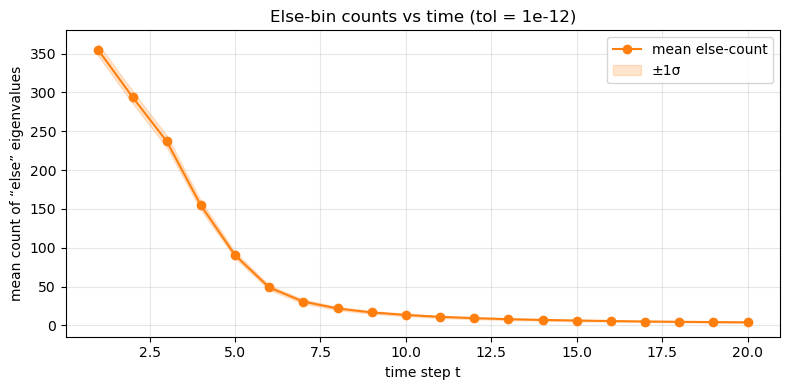

In [ ]:
from tqdm.auto import tqdm

tol = 1e-12
S, T = G_mixed.shape[:2]
else_counts = np.empty((S, T), dtype=int)

for s in tqdm(range(S), desc="Trajectories"):
    for t in range(T):
        eigvals = np.linalg.eigvalsh(hermitian_flatten_covariance(G_mixed[s, t]))
        is_neg1 = np.isclose(eigvals, -1.0, atol=tol)
        is_pos1 = np.isclose(eigvals,  1.0, atol=tol)
        else_counts[s, t] = np.count_nonzero(~(is_neg1 | is_pos1))

mean_else = else_counts.mean(axis=0)
std_else = else_counts.std(axis=0, ddof=0)
time_steps = np.arange(1, T + 1)




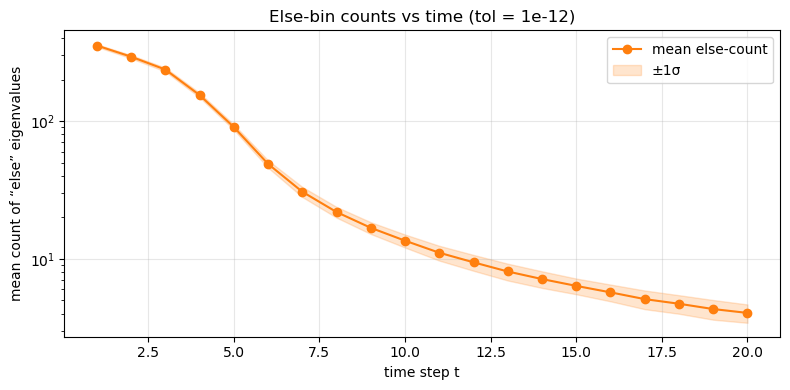

[354.53 294.01 237.11 154.67  90.58  48.87  30.68  21.85  16.78  13.53
  11.06   9.42   8.08   7.12   6.35   5.7    5.09   4.71   4.31   4.04]


In [47]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_steps, mean_else, marker='o', linestyle='-', color='C1', label='mean else-count')
ax.fill_between(time_steps, mean_else - std_else, mean_else + std_else,
                color='C1', alpha=0.2, label='±1σ')
ax.set_xlabel('time step t')
ax.set_ylabel('mean count of “else” eigenvalues')
ax.set_title(f'Else-bin counts vs time (tol = {tol:.0e})')
ax.legend()
ax.set_yscale('log')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print(mean_else)

In [ ]:
# --- Setup: assumes G_mixed and G_mixed_avg already exist ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def entanglement_contour_from_G6(G6):
    """Return s(x,y) for (..., Nx, Ny, 2, Nx, Ny, 2) covariances."""
    G6 = np.asarray(G6, dtype=np.complex128)
    if G6.ndim < 6:
        raise ValueError(f"G must have at least 6 dims; got {G6.shape}")

    Nx, Ny = G6.shape[-6], G6.shape[-5]
    leading = G6.shape[:-6]
    dim = 2 * Nx * Ny

    # flatten -> hermitise -> eigendecompose
    Gflat = flatten_G(G6)                                   # (..., dim, dim)
    Gflat = 0.5 * (Gflat + np.swapaxes(Gflat.conj(), -1, -2))
    evals, vecs = np.linalg.eigh(Gflat)
    evals_2pt = (1/2)*(evals+1) # covert to two point from complex covar
    evals_2pt = np.clip(np.real_if_close(evals_2pt), 1e-12, 1 - 1e-12)
    weights = -(evals_2pt * np.log(evals_2pt) + (1 - evals_2pt) * np.log(1 - evals_2pt))

    diagF = np.einsum("...ik,...k,...ik->...i", vecs, weights, vecs.conj(), optimize=True).real

    # reshape diag back to (μ, x, y), then sum over μ
    diagF = diagF.reshape(leading + (2, Nx, Ny), order="F")
    return diagF.sum(axis=-3)

def _pick_x_positions(m, Nx):
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL = int(m.DW_loc[0]) % Nx
        xR = int(m.DW_loc[1]) % Nx
        candidates = [
            (xL // 2) % Nx,
            (xL - 1) % Nx, xL, (xL + 1) % Nx,
            ((xL + xR) // 2) % Nx,
            (xR - 1) % Nx, xR, (xR + 1) % Nx,
            (xR + (Nx // 2)) % Nx,
        ]
        seen, uniq = set(), []
        for x in candidates:
            if x not in seen:
                uniq.append(int(x))
                seen.add(int(x))
        return uniq
    return [int(x) for x in np.linspace(0, Nx - 1, 9, dtype=int)]

traj_contours = entanglement_contour_from_G6(G_mixed)      # shape (S, T, Nx, Ny)
traj_mean_maps = traj_contours.mean(axis=0)                # ⟨s_G⟩ over samples
avg_maps = entanglement_contour_from_G6(G_mixed_avg)       # shape (T, Nx, Ny)
t_vals = np.arange(1, traj_contours.shape[1] + 1, dtype=float)
Nx, Ny = traj_contours.shape[2], traj_contours.shape[3]
x_list = _pick_x_positions(m, Nx)

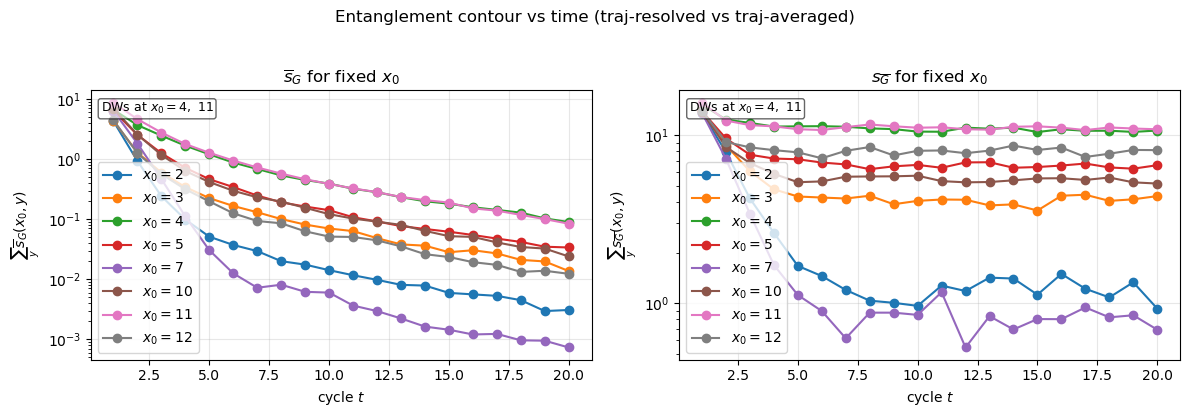

In [ ]:
# --- Cell 1: profiles vs time ---

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for x0 in x_list:
    axes[0].plot(t_vals, traj_mean_maps[:, x0, :].sum(axis=-1),
                 marker='o', label=fr'$x_0={x0}$')
axes[0].set_title(r'$\overline{s}_G$ for fixed $x_0$')
axes[0].set_xlabel('cycle $t$')
axes[0].set_ylabel(r'$\sum_y \overline{s}_G(x_0,y)$')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)

for x0 in x_list:
    axes[1].plot(t_vals, avg_maps[:, x0, :].sum(axis=-1),
                 marker='o', label=fr'$x_0={x0}$')
axes[1].set_title(r'$s_{\overline{G}}$ for fixed $x_0$')
axes[1].set_ylabel(r'$\sum_y s_{\overline{G}}(x_0,y)$')
axes[1].set_xlabel('cycle $t$')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)
axes[1].legend(ncol=2, fontsize=8)

for ax in axes:
    if hasattr(m, "DW_loc") and isinstance(m.DW_loc, (list, tuple)) and len(m.DW_loc) == 2:
        xL, xR = map(int, m.DW_loc)
        ax.text(
            0.02,
            0.96,
            fr"DWs at $x_0 = {xL},\ {xR}$",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="k", alpha=0.6),
        )
    ax.set_xlabel('cycle $t$')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    ax.legend()

plt.suptitle('Entanglement contour vs time (traj-resolved vs traj-averaged)', y=1.03)
plt.tight_layout()
plt.show()

In [24]:
# --- Cell 2: animation of the full contour dynamics ---

vmax = max(traj_mean_maps.max(), avg_maps.max())
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

im0 = axes[0].imshow(traj_mean_maps[0], cmap='Blues', origin='upper',
                     aspect='equal', vmin=0, vmax=vmax)
im1 = axes[1].imshow(avg_maps[0], cmap='Blues', origin='upper',
                     aspect='equal', vmin=0, vmax=vmax)

axes[0].set_title(rf'$\langle s_G \rangle$ (t=1)')
axes[1].set_title(rf'$s_\overline{G}$ (t=1)')
for ax in axes:
    ax.set_xlabel('$y$')
    ax.set_ylabel('$x$')

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04,
             label=r'$\langle s_G \rangle$')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04,
             label=r'$s_{\overline{G}}$')

def update(frame):
    im0.set_data(traj_mean_maps[frame])
    im1.set_data(avg_maps[frame])
    axes[0].set_title(rf'$\langle s_G \rangle$ (t={frame + 1})')
    axes[1].set_title(rf'$s_\overline{G}$ (t={frame + 1})')
    return im0, im1

ani = animation.FuncAnimation(fig, update, frames=traj_mean_maps.shape[0],
                              interval=400, blit=False)
ani  # notebook renders inline


Error in callback <function flush_figures at 0x7d1c9754b060> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
# --- Cell 3: final-time heatmaps ---

final_traj = traj_mean_maps[-1]
final_avg = avg_maps[-1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
im0 = axes[0].imshow(final_traj, cmap='Blues', origin='upper', aspect='equal')
im1 = axes[1].imshow(final_avg, cmap='Blues', origin='upper', aspect='equal')

axes[0].set_title(r'Final $\langle s_G \rangle$')
axes[1].set_title(r'Final $s_{\overline{G}}$')
for ax in axes:
    ax.set_xlabel('$y$')
    ax.set_ylabel('$x$')

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label=r'$\langle s_G \rangle$')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label=r'$s_{\overline{G}}$')

plt.suptitle('Final entanglement contour maps (maximix start)', y=1.03)
plt.tight_layout()
plt.show()